In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import importance_sampler_poise
import kl_divergence_calculator
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
import random
random.seed(30)

importing Jupyter notebook from importance_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb


In [2]:
def sample(mu, var, nb_samples):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [torch.normal(mu, var.sqrt())]
    return torch.stack(out, dim=0)
## Creating synthetic datasets
nb_samples=5000
mu1  =torch.tensor(0.)   # . converts long to float
var1 =torch.tensor(1.0)
mu2  =torch.tensor(0.)   # . converts long to float
var2 =torch.tensor(1.0)

inp_data1=sample(mu1,var1,nb_samples)  
inp_data1=inp_data1.unsqueeze(0)+torch.randn_like(inp_data1)##Adding gaussian noise to data
inp_data1=torch.transpose(inp_data1,0,1)

inp_data2=sample(mu2,var2,nb_samples)
inp_data2=inp_data2.unsqueeze(0)+torch.randn_like(inp_data2)  ##Adding gaussian noise to data
inp_data2=torch.transpose(inp_data2,0,1)

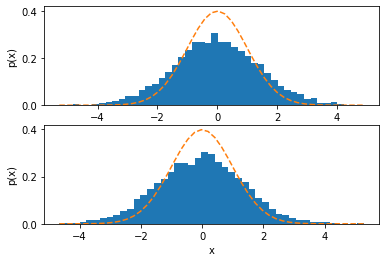

mu1 tensor(0.)
var1 tensor(1.)
mu2 tensor(0.)
var2 tensor(1.)


In [3]:
## for data visualization
data_vis1=inp_data1.numpy()
data_vis2=inp_data2.numpy()
fig, ax = plt.subplots(2,1)
#flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
#Panel a
n1,bins1,patches1=ax[0].hist(data_vis1,'auto',density=1)
y1=1/(np.sqrt(2*np.pi*var1))*np.exp(-0.5*(bins1-mu1.numpy())**2/var1)
ax[0].plot(bins1,y1,'--')
ax[0].set(xlabel='x',ylabel='p(x)')
#Panel b
n2,bins2,patches2=ax[1].hist(data_vis2,'auto',density=1)
y2=1/(np.sqrt(2*np.pi*var2))*np.exp(-0.5*(bins2-mu2.numpy())**2/var2)
ax[1].plot(bins2,y2,'--')
ax[1].set(xlabel='x',ylabel='p(x)')
plt.show()
print("mu1",mu1)
print("var1",var1)
print("mu2",mu2)
print("var2",var2)

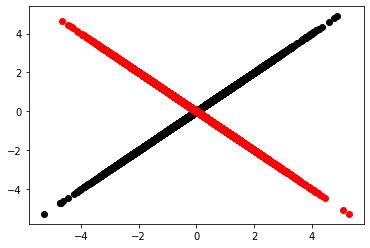

In [4]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 2
#fun_A1   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
#fun_A2   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
fun_A1 = torch.tensor([1,1])
fun_A2 = torch.tensor([1,-1])
data1    = inp_data1*fun_A1
data2    = inp_data2*fun_A2
x1_cord = data1[:,0]
y1_cord = data1[:,1]
x2_cord = data2[:,0]
y2_cord = data2[:,1]
plt.plot(x1_cord,y1_cord, 'o', color='black')
plt.plot(x2_cord,y2_cord, 'o', color='red')
plt.show()

In [5]:
## Hyperparameters
batch_size = 128
latent_dim1 = 1
latent_dim2 = 1
lr         = 1e-3
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
## Creating synthetic dataloader
train_loader_set1 = DataLoader(
    data1[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set1 = DataLoader(
    data1[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
train_loader_set2 = DataLoader(
    data2[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set2 = DataLoader(
    data2[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [18]:
## Neural net is like: [mu,logvar]=(relu(xA))B,x=sig((relu(zC))D)        
class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.kl_div                  = kl_divergence_calculator.kl_divergence(self.latent_dim1, self.latent_dim2, self.batch_size)
        self.IS_sampler              = importance_sampler_poise.importance_sampler(self.latent_dim1, self.latent_dim2, self.batch_size)
        self.n_IW_samples = 10
        ## Decoder set1
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = dim_exp,bias=False)
        ## Decoder set2
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = dim_exp,bias=False)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim1)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.g12   = torch.zeros(latent_dim1,latent_dim2).to(device)
    def weighted_mse_loss(self,weights,reconstruction,data):
        #weights :[batch_size], reconstruction: [batch_size,2], data: [batch_size,2] , loss: #
        loss = torch.sum(weights * ((data - reconstruction) ** 2).T)
        return loss
    def encoder1(self,x):
        self.set1_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim1).to(device)
        self.set1_enc2 = nn.Linear(in_features = 2*latent_dim1,out_features = 2*latent_dim1).to(device)
        x       = self.set1_enc1(x)
        x       = self.set1_enc2(x)
        mu      = x[:,0]
        mu      = mu.unsqueeze(0)
        mu      = torch.transpose(mu,0,1)    
        log_var = x[:,1]
        log_var = log_var.unsqueeze(0)
        log_var = torch.transpose(log_var,0,1)    
        var     = -torch.exp(log_var)     #lambdap_2<0
        return mu, var
    def encoder2(self,x):
        self.set2_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim2).to(device)
        self.set2_enc2 = nn.Linear(in_features = 2*latent_dim2,out_features = 2*latent_dim2).to(device)
        x       = self.set2_enc1(x)
        x       = self.set2_enc2(x)     
        mu      = x[:,0]
        mu      = mu.unsqueeze(0)
        mu      = torch.transpose(mu,0,1)    
        log_var = x[:,1]
        log_var = log_var.unsqueeze(0)
        log_var = torch.transpose(log_var,0,1)    
        var     = -torch.exp(log_var)     #lambdap_2<0
        return mu, var
    def forward(self,x):
        x1,x2    = x
        data1    = x1
        data2    = x2
        ## encoding
        mu1,var1 = self.encoder1(x1) # Modality 1       
        mu2,var2 = self.encoder2(x2) # Modality 2         
        g22      = -torch.exp(self.g22)        
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)
        z1_prior,z2_prior,z1_posterior,z2_posterior,IS_weights_prior,IS_weights_post = self.IS_sampler.calc(G,mu1,var1,mu2,var2,self.n_IW_samples)
        ## decoding
        loss = 0
        weighted_reconstruction1 = torch.zeros_like(data1)              #[batch_size,2]
        weighted_reconstruction2 = torch.zeros_like(data2)
        for i in range(self.n_IW_samples):
            self.z1_IS_prior     = z1_prior[i]
            self.z2_IS_prior     = z2_prior[i]
            self.z1_IS_posterior = z1_posterior[i]
            self.z2_IS_posterior = z2_posterior[i]
            part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_IS_posterior,self.z2_IS_posterior,self.z1_IS_prior,self.z2_IS_prior,mu1,var1,mu2,var2)
            reconstruction1      = (self.set1_dec1(self.z1_IS_posterior.unsqueeze(0))).squeeze()
            reconstruction2      = (self.set2_dec1(self.z2_IS_posterior.unsqueeze(0))).squeeze()
            ## loss
            MSE1 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction1, data1)
            MSE2 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction2, data2)
#             KLD  = torch.sum(IS_weights_post[i,:]*(torch.sum(part_fun0+part_fun1,dim=1)+part_fun2) )
            loss = loss + MSE1 + MSE2 
            weighted_reconstruction1 = weighted_reconstruction1 + (IS_weights_post[i,:]*reconstruction1.T).T
            weighted_reconstruction2 = weighted_reconstruction2 + (IS_weights_post[i,:]*reconstruction2.T).T
#         print(IS_weights_post[:,i].size())
#         print('hello',IS_weights_post[i,:].size())
        return weighted_reconstruction1,weighted_reconstruction2,mu1,var1,mu2,var2,loss

In [15]:
model = VAE(latent_dim1, latent_dim2, batch_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_dec1.weight
set2_dec1.weight


In [16]:
def train(model,dataloader1,dataloader2):
    model.train()
    running_loss = 0
    for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
        data1                        = data1.to(device)
        data2                        = data2.to(device)   
        optimizer.zero_grad()
        data = [data1,data2]
        reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss       = model(data)
        running_loss                += loss.item()
        loss.backward() 
        optimizer.step()
    train_loss = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    return train_loss
def test(model,dataloader1,dataloader2):
    mean1_pred = []
    var1_pred  = []
    mean2_pred = []
    var2_pred  = []
    data1_val  = [] 
    data2_val  = [] 
    reconstruction1_pred=[]
    reconstruction2_pred=[]
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
            data1                        = data1.to(device)
            data2                        = data2.to(device)    
            data = [data1,data2]
            reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss = model(data)  
            running_loss              += loss.item()
            mean1_pred                += [torch.mean(mu1)]
            var1_pred                 += [torch.mean(var1)]
            mean2_pred                += [torch.mean(mu2)]
            var2_pred                 += [torch.mean(var2)]
            reconstruction1_pred.append(reconstruction1)
            reconstruction2_pred.append(reconstruction2)
            data1_val.append(data1)
            data2_val.append(data2)

    test_loss   = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    reconstruction1_pred = torch.vstack(reconstruction1_pred)
    reconstruction2_pred = torch.vstack(reconstruction2_pred)
    data1_val   = torch.vstack(data1_val)
    data2_val   = torch.vstack(data2_val)

    mean1_pred  = torch.stack(mean1_pred,dim=0)
    var1_pred   = torch.stack(var1_pred,dim=0)
    mean1_pred  = torch.mean(mean1_pred)
    var1_pred   = torch.mean(var1_pred)
    mean2_pred  = torch.stack(mean2_pred,dim=0)
    var2_pred   = torch.stack(var2_pred,dim=0)
    mean2_pred  = torch.mean(mean2_pred)
    var2_pred   = torch.mean(var2_pred)
    return data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_loss,mean1_pred,var1_pred,mean2_pred,var2_pred

In [17]:
epochs     = 100
train_loss = []
test_loss = []
from tqdm import tqdm
for epoch in tqdm(range(epochs)):
#     print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader_set1,train_loader_set2)
    data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,test_loader_set1,test_loader_set2)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
#     for name, para in model.named_parameters():
#         print(para)
    print(f"Train Loss    : {train_epoch_loss:.4f}")
print(f"Test Loss     :  {test_epoch_loss:.4f}")
print(f"Mean Pred set1:  {mean1_pred:.4f}")
print(f"Var  Pred set1:  {var1_pred:.4f}")
print(f"Mean Pred set2:  {mean2_pred:.4f}")
print(f"Var  Pred set2:  {var2_pred:.4f}")

  1%|          | 1/100 [00:02<04:29,  2.72s/it]

Train Loss    : 4.2298


  2%|▏         | 2/100 [00:05<04:27,  2.73s/it]

Train Loss    : 4.3831


  3%|▎         | 3/100 [00:08<04:38,  2.87s/it]

Train Loss    : 4.2979


  3%|▎         | 3/100 [00:11<05:57,  3.69s/it]


KeyboardInterrupt: 

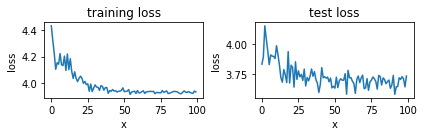

In [11]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

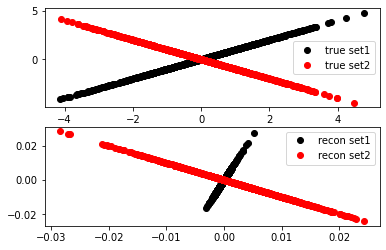

In [12]:
reconstruction1_pred =np.reshape(reconstruction1_pred.cpu().detach().numpy(),(896,2))
reconstruction2_pred =np.reshape(reconstruction2_pred.cpu().detach().numpy(),(896,2))
# reconstruction1_pred =np.reshape(reconstruction1_pred,(896,2))
# reconstruction2_pred =np.reshape(reconstruction2_pred,(896,2))
reconstruction1_x_cord = reconstruction1_pred[:,0]
reconstruction1_y_cord = reconstruction1_pred[:,1]
reconstruction2_x_cord = reconstruction2_pred[:,0]
reconstruction2_y_cord = reconstruction2_pred[:,1]
data1_x_cord = data1_val[:,0].cpu().detach().numpy()
data1_y_cord = data1_val[:,1].cpu().detach().numpy()
data2_x_cord = data2_val[:,0].cpu().detach().numpy()
data2_y_cord = data2_val[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)

ax[0].plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
ax[0].plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
ax[0].legend()
ax[1].plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='black',label='recon set1')
ax[1].plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='red',label='recon set2')
ax[1].legend()
plt.show()

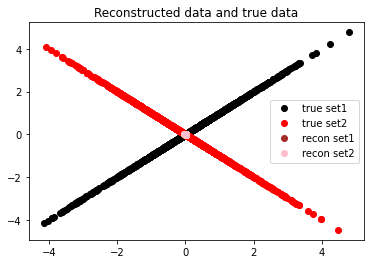

In [13]:
plt.plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
plt.plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
plt.plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='brown',label='recon set1')
plt.plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='pink',label='recon set2')
plt.title('Reconstructed data and true data')
plt.legend()
plt.show()